In [ ]:
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Name: Jonah Zembower
# Date: March 11, 2025
# Project: EY 2025 Data Science Challenge
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Introduction:

We have had a lot of success with different methods having an accuracy of 0.92. Now, we are going to try a new method of stacking these models together to see if we can come up with better results.

# Libraries and Data:


Importing necessary libraries:

In [2]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For the geodataframe
import geopandas as gpd
from shapely import wkt
from scipy.spatial import cKDTree

# Stacking libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

Importing Data:

In [3]:
# Satellite Data:
all_bands_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_granular.csv")
all_bands_noisy_proximity = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_noisy_proximity.csv")
all_bands_proximity_noisy = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_proximity_noisy.csv")
all_bands_proximity_rounded_3 = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_proximity_rounded_3.csv")
all_bands_proximity_rounded_3_mapped = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_proximity_rounded_3_mapped.csv")
indices_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\indices_granular.csv")
landsat_thermal_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_thermal_granular.csv")
noisy_long_lat_uhi = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\noisy_long_lat_uhi.csv")

In [4]:
# Elevation Data:
all_elevation_nyc = pd.read_csv("C:\\Users\\jrzem\OneDrive\\Desktop\\EY Dataset\\Elevation\\all_elevation_nyc.csv")

In [5]:
# Load the test data
test_data = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Submission_template.csv")

# Stacking Models:

1. sentinel (BO1, BO6 proximity) and elevation (building height only and natural elevation proximity)

In [9]:
# Add the landsat_thermal_granular data to the all_bands_proximity_rounded_3_mapped data
all_bands_elevation_2 = all_bands_proximity_rounded_3_mapped.merge(all_elevation_nyc[['Longitude', 'Latitude', 'Building Height Only Proximity','Natural Proximity']], on=['Longitude', 'Latitude'])
all_bands_elevation_2

# Save to CSV
all_bands_elevation_2.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_2.csv", index=False)

# Load dataset
all_bands_elevation_2 = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_2.csv")

In [10]:
# Load dataset
df = all_bands_elevation_2.copy()

# Define spectral features
spectral_features = ['BO1', 'BO6', 'Building Height Only Proximity','Natural Proximity']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=9, random_state=42)),
    ('lgb', LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=15, random_state=42))
]

# Meta-learner (final model)
stack_model = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# Train model
stack_model.fit(X_train_scaled, y_train)

# Predict & evaluate
y_pred_stack = stack_model.predict(X_test_scaled)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"Stacked Model Performance:\n - MAE: {mae_stack:.4f}\n - RMSE: {rmse_stack:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 4
[LightGBM] [Info] Start training from score 1.000008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 7186, number of used features: 4
[LightGBM] [Info] Start training from score 1.000045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the tr

In [12]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, all_bands_elevation_2)

In [13]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions = stack_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions

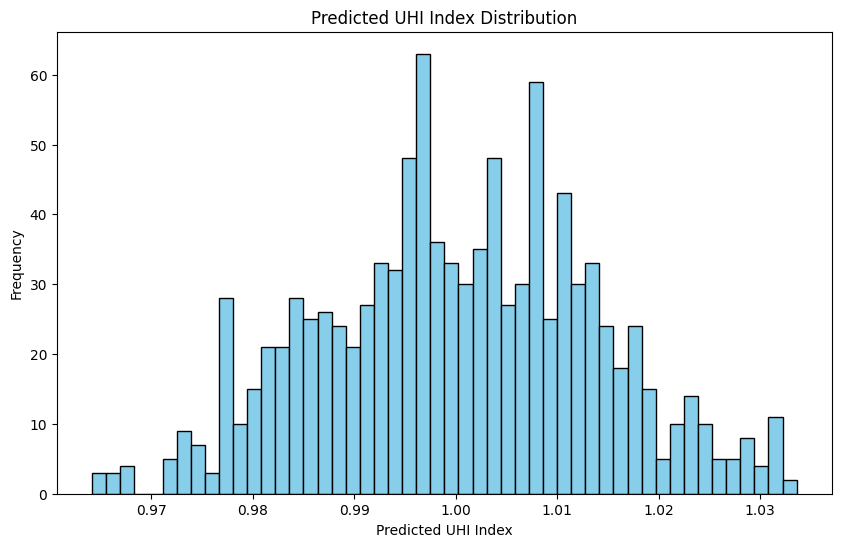

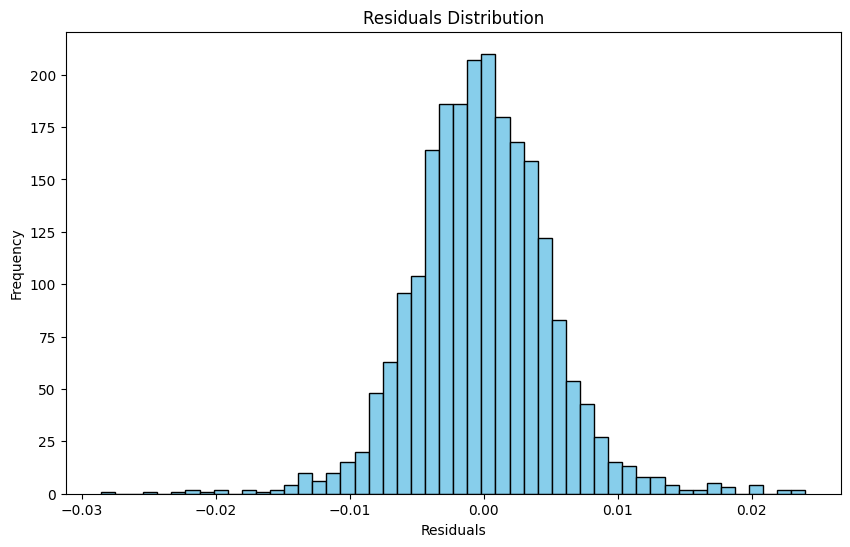

In [14]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist(submission_predictions, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Frequency')
plt.title('Predicted UHI Index Distribution')
plt.show()

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred_stack, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

In [16]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This was slightly worse with 0.9063 accuracy when submitted. 

# Conclusion: